# Evaluation Notebook: Cat-Dog Image Classification

Author: **hnthap**

In [1]:
from datetime import datetime, timezone
import gc
import os
import random

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models
import torchvision.transforms as transforms


plt.style.use('default')

In [2]:
!python -c "import sys; print('python', sys.version)"
!python -c "import PIL; print('PIL', PIL.__version__)"
!python -c "import numpy; print('numpy', numpy.__version__)"
!python -c "import polars; print('polars', polars.__version__)"
!python -c "import torch; import torchvision; print('torch', torch.__version__); print('torchvision', torchvision.__version__)"

python 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
PIL 10.3.0
numpy 2.0.1
polars 1.21.0
torch 2.5.1
torchvision 0.20.1


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device != 'cpu':
    print('CUDA Device:', torch.cuda.get_device_name(device))

CUDA Device: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
def flush(*, verbose=True):
    if verbose:
        print('GC collected', gc.collect())
    else:
        gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

flush()

GC collected 36


In [5]:
def now_str():
    '''
    Returns a string representation of the current time (UTC).
    '''
    return datetime.now(timezone.utc).strftime('%Y%m%d-%H%M%S-%f')

now_str()

'20250314-132425-486829'

In [6]:
CHECKPOINT_DIR = '../checkpoint/'


def save_model(model, optimizer, model_name='model', **kwargs):
    checkpoint_path = os.path.join(
        CHECKPOINT_DIR, f'ckpt-{model_name}-{now_str()}.pth'
    )
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        **kwargs
    }, checkpoint_path)
    print('Model saved:', checkpoint_path)
    return checkpoint_path


def load_model(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint['model_state_dict']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    del checkpoint['optimizer_state_dict']
    print('Model loaded:', checkpoint_path)
    return checkpoint


def load_checkpoint_result(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    del checkpoint['model_state_dict']
    del checkpoint['optimizer_state_dict']
    return checkpoint


os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## Data

In [7]:
IMAGE_DIR = '../data/PetImages/'

In [8]:
flush()

GC collected 0


In [9]:
cat_dog_df = pl.read_csv('cat-dog.csv')

print(cat_dog_df.filter(pl.col('split') == 'test').sample(5, seed=10))

shape: (5, 4)
┌───────┬───────────┬────────┬───────┐
│ label ┆ filename  ┆ is_cat ┆ split │
│ ---   ┆ ---       ┆ ---    ┆ ---   │
│ str   ┆ str       ┆ i64    ┆ str   │
╞═══════╪═══════════╪════════╪═══════╡
│ Cat   ┆ 11030.jpg ┆ 1      ┆ test  │
│ Cat   ┆ 3240.jpg  ┆ 1      ┆ test  │
│ Dog   ┆ 4033.jpg  ┆ 0      ┆ test  │
│ Cat   ┆ 602.jpg   ┆ 1      ┆ test  │
│ Cat   ┆ 3823.jpg  ┆ 1      ┆ test  │
└───────┴───────────┴────────┴───────┘


## Preprocessing

In [22]:
class CatDogDataset(Dataset):

    def __init__(self, image_dir, data, transform=None):
        self.image_dir = image_dir
        self.data = data
        self.transform = transform


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        row = self.data.row(idx)
        file_path = os.path.join(self.image_dir, row[0], row[1])
        with Image.open(file_path, 'r').convert('RGB') as image:
            if self.transform:
                image = self.transform(image)
            return image, row[2]
        

    def get_image_path(self, idx):
        row = self.data.row(idx)
        return os.path.join(self.image_dir, row[0], row[1])


In [23]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
test_dataset = CatDogDataset(IMAGE_DIR, cat_dog_df.filter(pl.col('split') == 'test'), transform)

print('Test data size:', len(test_dataset))

Test data size: 2000


Input shape: torch.Size([3, 224, 224])
Label: 1


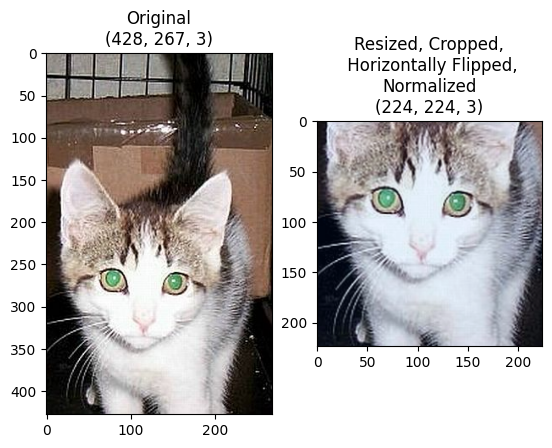

In [25]:
idx = 1200

if idx < 0 or idx >= len(test_dataset):
    raise IndexError('index out of range, must be between 0 and %d' % (len(test_dataset) - 1))

inp, label = test_dataset[idx]
print('Input shape:', inp.size())
print('Label:', label)

inp = inp.detach().numpy()
inp = ((inp - inp.min()) * 255 / (inp.max() - inp.min() + 1e-9)).astype(int)
inp = np.moveaxis(inp, 0, -1)

plt.subplot(1, 2, 1)
with Image.open(test_dataset.get_image_path(idx), 'r') as image:
    plt.imshow(image.convert('RGB'))
    plt.title('Original\n' + str(np.asarray(image.convert('RGB')).shape))
plt.subplot(1, 2, 2)
plt.imshow(inp)
plt.title('Resized, Cropped,\n Horizontally Flipped,\nNormalized\n'
          + str(inp.shape))
plt.show()

## Model: EfficientNet-B0

* EfficientNet: [paper](https://arxiv.org/pdf/1905.11946)
* MnasNet (EfficientNet architecture): [paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Tan_MnasNet_Platform-Aware_Neural_Architecture_Search_for_Mobile_CVPR_2019_paper.pdf)

In [26]:
class CatDogModelA(nn.Module):

    def __init__(self):
        super(CatDogModelA, self).__init__()
        self.net = torchvision.models.efficientnet_b0()
        for i in range(6):
            for param in self.net.features[i].parameters():
                param.requires_grad = False
        self.net.classifier[1] = nn.Linear(self.net.classifier[1].in_features, 2)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.net(x)
        x = self.softmax(x)
        return x

In [27]:
model_a = CatDogModelA().to(device)
optimizer = optim.Adam(model_a.parameters(), lr=0.001)

checkpoint_path = '../checkpoint/ckpt-a-20250314-092618-383242.pth'
load_model(model_a, optimizer, checkpoint_path)

Model loaded: ../checkpoint/ckpt-a-20250314-092618-383242.pth


{'train_loss': 0.3313359293306983,
 'train_acc': 98.09982725702336,
 'val_loss': 0.3251131735742092,
 'val_acc': 98.89999999999989}

In [28]:
flush()

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss()
num_epochs = 5
history = { 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }
false_positive = set()

model_a.eval()
running_loss = 0.0
correct_count = 0
total_count = 1e-12  # A very small number to avoid division by zero
with torch.no_grad():
    for inps, labels in tqdm(test_dataloader):
        inps = inps.to(device)
        labels = labels.to(device)
        outputs = model_a(inps)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_count += labels.size(0)
        correct_count += (predicted == labels).sum().item()
epoch_loss = running_loss / len(test_dataloader)
epoch_accuracy = 100.0 * correct_count / total_count
print('Test loss: %.4f | Test accuracy: %.4f%%' % (epoch_loss, epoch_accuracy))

GC collected 17094


100%|██████████| 63/63 [00:14<00:00,  4.30it/s]

Test loss: 0.3283 | Test accuracy: 98.3500%
